# AllCorrect DS Project

# Task
Build an algorithm for classification of user reviews into one of the four categories.
The quality of the algorithm should be evaluated using hold-out subset or crossvalidation technique.

In [1]:
#hide
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/data/reviews.xlsx'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Plan**

1.   [Data Preprocessing](#Preprocessing)
2.   [EDA](#EDA)
3.  [Baseline model + TFDIF](#Baseline-model-+-TFDIF)
  *   [Train and test split](#Train-and-test-split)
  *   [Vectorization](#Vectorization)
  *   [Training](#Training)
4.  [CatBoost](CatBoost)
5.  [BERT embedding](#BERT-embedding)
6.  [Keras + BERT](#Keras-+-BERT)
7.  [Conclusion](#Conclusion)
8.  [Python script](#Python-script)

Let's import all needed libs

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
#hide
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
#hide
!pip install catboost

In [5]:
#hide
!pip install transformers

In [6]:
import torch
import transformers
from tqdm.auto import tqdm

In [7]:
import pandas as pd
import numpy as np
import re
import math
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

from catboost import CatBoostClassifier, Pool
import joblib

In [8]:
df =  pd.read_excel(path)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51800 entries, 0 to 51799
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      51800 non-null  int64 
 1   mark    51800 non-null  object
 2   review  51800 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [10]:
df.iloc[0]

id                                                     6720
mark                                                     RL
review    It's not Turkish, it's a lie, but I recommend ...
Name: 0, dtype: object

# Preprocessing


In [11]:
lemmatizer = WordNetLemmatizer()

def clean_text(text):
  #lower
  text = text.strip().lower()
  #clear the text
  text = re.sub(r"[^a-zA-Z']+", ' ', text)
  #lemmatization
  tokens = word_tokenize(text)
  lemmas = [lemmatizer.lemmatize(word) for word in tokens]

  return " ".join(lemmas)

df['review'] = df['review'].apply(clean_text)

In [12]:
df['review_len'] = df['review'].str.len()
df = df.sort_values('review_len',axis=0)
df.head()

,id,mark,review,review_len
8779,47782,YL,,0
48906,24112,RL,,0
45267,7454,RL,,0
26259,27730,RL,,0
14029,47768,RL,,0


In [13]:
df[df['review_len'] == 0]['review_len'].count()

14

In [14]:
df = df[df['review_len'] != 0]

In [15]:
df['mark'] = df['mark'].str.upper()
df['mark'].unique()

array(['RL', 'L-', 'L+', 'YL'], dtype=object)

In [16]:
encoder = LabelEncoder()
df['mark_num'] = encoder.fit_transform(df['mark'])

In [17]:
df['mark_num'].unique()

array([2, 1, 0, 3])

# EDA

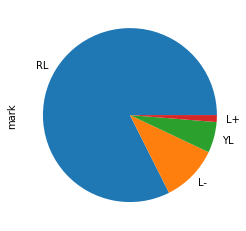

In [18]:
df['mark'].value_counts(normalize=True).plot(kind='pie')

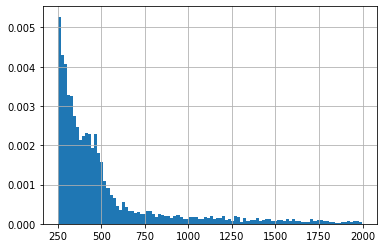

In [19]:
df[(df['review_len'] < 2000) & (df['review_len'] > 250)]['review_len'].hist(bins=100,density=True)

The data is unbalanced. There is 82% of the one type out of four.

Most of reviews are not longer than 500 signs. 

# Baseline Model + TFIDF

## Train and test split

In [20]:
stop_words = set(stopwords.words('english'))
corpus = df['review']

In [21]:
X = df['review']
y = df['mark_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Vectorization

In [22]:
count_tf_idf = TfidfVectorizer(stop_words = stop_words)
tf_idf_train = count_tf_idf.fit_transform(X_train)
tf_idf_test = count_tf_idf.transform(X_test)

## Training 

In [23]:
lr_model = LogisticRegression(multi_class='ovr', solver='liblinear')
lr_model.fit(tf_idf_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
y_pred = lr_model.predict(tf_idf_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.02      0.04       133
           1       0.80      0.68      0.73      1096
           2       0.91      0.99      0.94      8537
           3       0.70      0.18      0.29       592

    accuracy                           0.89     10358
   macro avg       0.79      0.47      0.50     10358
weighted avg       0.88      0.89      0.87     10358



In [25]:
print(confusion_matrix(y_test, y_pred))

[[   3   45   70   15]
 [   1  742  350    3]
 [   0   97 8412   28]
 [   0   42  443  107]]


In [26]:
print(f1_score(y_test, y_pred, average='weighted'))

0.8731152130914144


In [27]:
print(accuracy_score(y_test, y_pred))

0.8943811546630623


# CatBoost




In [28]:
X = df[['review', 'id']]
y = df['mark_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [29]:
train_pool = Pool(data=X_train,
                  label=y_train, 
                  text_features=['review']) 
valid_pool = Pool(data=X_test, 
                  label=y_test, 
                  text_features=['review']) 
model_CB = CatBoostClassifier(loss_function='MultiClass')

In [30]:
# model_CB.fit(train_pool, eval_set=valid_pool)


# joblib.dump(model_CB, '/content/drive/My Drive/data/model_CB.joblib')
model_CB = joblib.load('/content/drive/My Drive/data/model_CB.joblib')
y_pred = model_CB.predict(X_test)
# print(model_CB.get_best_score())

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.23      0.35       133
           1       0.82      0.78      0.80      1096
           2       0.94      0.98      0.96      8537
           3       0.79      0.43      0.56       592

    accuracy                           0.92     10358
   macro avg       0.81      0.61      0.67     10358
weighted avg       0.91      0.92      0.91     10358



In [32]:
print(f1_score(y_test, y_pred, average='weighted'))

0.9115470087472277


In [33]:
print(accuracy_score(y_test, y_pred))

0.9196756130527128


# BERT embedding


In [34]:
bert_tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [35]:
#collapse_output
bert_model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
def BERT_process(texts, max_length=512, batch_size=100, disable_progress_bar=True):

  ids_list = []
  attention_mask_list = []

  # text to padded IDs of tokens along with their attention masks
  
  for input_text in tqdm(texts, disable=disable_progress_bar):
      ids = bert_tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
      padded = np.array(ids + [0]*(max_length - len(ids)))
      attention_mask = np.where(padded != 0, 1, 0)
      ids_list.append(padded)
      attention_mask_list.append(attention_mask)
  # use cuda if possible: 

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  bert_model.to(device)
  
  # gettings embeddings in batches

  embeddings = []

  for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
          
      ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
      attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
          
      with torch.no_grad():            
          bert_model.eval()
          batch_embeddings = bert_model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
      embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
  return np.concatenate(embeddings)


# Keras + BERT

In [37]:
# X = BERT_process(df['review'])
# np.savez_compressed('/content/drive/My Drive/data/X_BERT.npz', X=X)
with np.load('/content/drive/My Drive/data/X_BERT.npz') as data:
    X = data['X']

In [38]:
y = df['mark_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [39]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5)

In [40]:
y_train = np.asarray(y_train).astype(np.float32)
train_dataset = tf.data.Dataset.from_tensor_slices((
    X_train,
    y_train
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    X_test,
    y_test
))

In [41]:
#collapse_output
model = keras.models.Sequential()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(128, activation='softmax'))
# model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')
model.compile(
    optimizer=optimizer,  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
model.fit(train_dataset.shuffle(1000).batch(16), epochs=3, batch_size=16, validation_data=(X_val, y_val))
y_pred = model.predict(X_test, verbose=True).argmax(axis=-1)

Epoch 1/3
2266/2266 [==============================] - 6s 2ms/step - loss: 0.4185 - sparse_categorical_accuracy: 0.8592 - val_loss: 0.3678 - val_sparse_categorical_accuracy: 0.8704
Epoch 2/3
2266/2266 [==============================] - 5s 2ms/step - loss: 0.3630 - sparse_categorical_accuracy: 0.8734 - val_loss: 0.3487 - val_sparse_categorical_accuracy: 0.8791
Epoch 3/3
243/243 [==============================] - 0s 934us/step


In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.29      0.06      0.11       108
           1       0.63      0.72      0.67       786
           2       0.92      0.96      0.94      6427
           3       0.63      0.21      0.31       447

    accuracy                           0.88      7768
   macro avg       0.62      0.49      0.51      7768
weighted avg       0.86      0.88      0.86      7768



In [43]:
print(f1_score(y_test, y_pred, average='weighted'))

0.8615621529186347


In [44]:
print(accuracy_score(y_test, y_pred))

0.8761585993820803


# Conclusion
The score of deep-learning model + BERT is the lest than accuracy of a simple LogisticRegression model.

Probably it's because the data is unbalanced. If the data are a bit more balanced, perhaps we would have a better result.

I decided to continue with already trained Catboost model, that showed the best result, and create python script for production.

# Python script
Code of the python script to classify users' reviews.

**Input**: 

*   CatBoost model
*   Excel file with two columns. First column is unique identifier of the review, second column is review's text.

**Output**: 
*   Excel file with six columns. First two columns remain from the input file,  other columns contain probability to belong to each category.

```
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import joblib
import pandas as pd
from optparse import OptionParser
import re

parser = OptionParser()

parser.add_option("-t", "--text_file",
                  action="store", type="string", dest="text_path")
parser.add_option("-m", "--model_file",
                  action="store", type="string", dest="model_path")
(options, args) = parser.parse_args()


lemmatizer = WordNetLemmatizer()

def clean_text(text):
  #lower
  text = text.strip().lower()
  #clear the text
  text = re.sub(r"[^a-zA-Z']+", ' ', text)
  #lemmatization
  tokens = word_tokenize(text)
  lemmas = [lemmatizer.lemmatize(word) for word in tokens]

  return " ".join(lemmas)

def predict_mark(text):
  model = joblib.load(model_path)
  y_pred = model.predict(text_preprocessed) 
  return y_pred

df =  pd.read_excel(text_path)
df['review'] = df['review'].apply(clean_text)
df['mark'] = df['review'].apply(predict_mark)

df.to_excel("output.xlsx") 
```

